In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import random
#import pymc as pm
import datetime
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# CONFIG

**Set sample to False if you want to run algos on entire dataset**

In [25]:
CONFIG = {
    'sample': True,
    'sample_months': 1, # how many months to sample (for development)
    'choose_month': 5, # month to choose for sampling // Note: overrides sample_months
    'top_n_clusters': 1, # how many clusters to train
    'random_state': 123,
    'target_col': 'departures',
    'n_jobs': 4,  # gridsearch parallelization, might need to adjust based on your system
    'ts_splits': 5, # TimeSeriesSplit number of splits
    'ts_gap': 48,  # 2-day gap
    'visualize_clusters': False
}

FEATURE_COLS = {
    'categorical': ['isHoliday', 'has_kiosk', 'weather_cluster', 'workhours', 'commute', 'free', 'night'],
    'drop': ['sum', 'weather_code', 'timestamp', 'station_name', 'arrivals', 'num_docks_available', 'num_ebikes_available', 'capacity', 'cluster', 'sunset', 'sunrise', 'year', 'hour_extract', 'precipitation', 'wind_gusts_10m', 'dayofyear', 'dayofweek', 'delta'],
    'time': ['weekday', 'day', 'month', 'hour']
}

# DATA LOADING

In [26]:
df = pd.read_parquet("data/final/df.parquet")

In [27]:
FEATURE_COLS["drop"] = FEATURE_COLS["drop"] + [col for col in df.columns if (col.startswith("var") or col.startswith("avg"))]

In [28]:
print(df.shape)

(6464880, 94)


In [30]:
# REDUCE DATASET SIZE FOR DEVELOPMENT
if CONFIG['sample']:
    if CONFIG['choose_month'] is not None:
        df = df[df['timestamp'].dt.month == CONFIG['choose_month']]
        print(f'Chosen month: {CONFIG["choose_month"]}')
    else:
        months = df['timestamp'].dt.month.unique()
        random_month = random.sample(list(months), CONFIG['sample_months'])
        df = df[df['timestamp'].dt.month.isin(random_month)]
        print(f'Sampled {CONFIG["sample_months"]} month(s): {random_month}')

Chosen month: 5


In [31]:
df.head()

,station_name,hour,departures,arrivals,hour_extract,temperature_2m,weather_code,rain,precipitation,snowfall,...,var_sum_station_nonnight,avg_sum_station_holiday,var_sum_station_holiday,avg_sum_station_commute,var_sum_station_commute,avg_sum_station_free,var_sum_station_free,avg_sum_station_unfriendly_weather,var_sum_station_unfriendly_weather,cluster
2880,10th & E St NW,0,0.0,0.0,0,12.786000,2.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
2881,10th & E St NW,1,0.0,0.0,1,11.936000,1.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
2882,10th & E St NW,2,0.0,0.0,2,11.186000,3.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
2883,10th & E St NW,3,0.0,0.0,3,11.636001,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
2884,10th & E St NW,4,0.0,0.0,4,10.286000,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5


In [29]:
# Baseline-Performance for 0-heavy Data:
for i in range(0,10):
    df_cluster_subset = df[df["cluster"]==i]
    baseline = np.sqrt((sum(df_cluster_subset["departures"]**2))/len(df_cluster_subset))
    print(f"Baseline over all time cluster {i}: {baseline}")
print("---")
# TODO: Do we need to update this to conform with the "primary" train-test-split? (The one at the very top)
baseline = np.sqrt((sum(df["departures"]**2))/len(df))
print(f"Baseline over all time whole city: {baseline}")
print("---")
df_may_subset = df[(df["month"]==5) & (df["day"]>=10) & (df["day"]<=20)].copy()
for i in range(0,10):
    df_cluster_subset = df_may_subset[df_may_subset["cluster"]==i]
    baseline = np.sqrt((sum(df_cluster_subset["departures"]**2))/len(df_cluster_subset))
    print(f"Baseline over 10-20 may cluster {i}: {baseline}")
df_may_subset = df[(df["month"]==5) & (df["day"]>=21) & (df["day"]<=30)].copy()
for i in range(0,10):
    df_cluster_subset = df_may_subset[df_may_subset["cluster"]==i]
    baseline = np.sqrt((sum(df_cluster_subset["departures"]**2))/len(df_cluster_subset))
    print(f"Baseline over 21-30 may cluster {i}: {baseline}")

Baseline over all time cluster 0: 2.316139385547197
Baseline over all time cluster 1: 1.104808472655983
Baseline over all time cluster 2: 0.4637198876281428
Baseline over all time cluster 3: 0.7864280404968053
Baseline over all time cluster 4: 3.5115909397967626
Baseline over all time cluster 5: 2.5969880093352313
Baseline over all time cluster 6: 4.125818477787311
Baseline over all time cluster 7: 2.5778118929144425
Baseline over all time cluster 8: 0.5381255872385102
Baseline over all time cluster 9: 0.6125158954085695
---
Baseline over all time whole city: 1.6304479147363014
---
Baseline over 10-20 may cluster 0: 2.6057317658438466
Baseline over 10-20 may cluster 1: 1.2490472559591361
Baseline over 10-20 may cluster 2: 0.5400893375025043
Baseline over 10-20 may cluster 3: 0.9421146043436236
Baseline over 10-20 may cluster 4: 4.0827457833317435
Baseline over 10-20 may cluster 5: 2.955754414659583
Baseline over 10-20 may cluster 6: 4.672602181193581
Baseline over 10-20 may cluster 7: 

In [32]:
# All remaining columns are considered numerical
FEATURE_COLS['numerical'] = [col for col in df.columns if col not in ([CONFIG['target_col']] + FEATURE_COLS['categorical'] + FEATURE_COLS['drop'] + FEATURE_COLS['time'])]

## Feature sanity check

In [33]:
# Sanity check for features
print("Categorical:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['categorical']))
print("Drop:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['drop']))
print("Time:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['time']))
print("Numerical:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['numerical']))

Categorical:
  - isHoliday
  - has_kiosk
  - weather_cluster
  - workhours
  - commute
  - free
  - night
Drop:
  - sum
  - weather_code
  - timestamp
  - station_name
  - arrivals
  - num_docks_available
  - num_ebikes_available
  - capacity
  - cluster
  - sunset
  - sunrise
  - year
  - hour_extract
  - precipitation
  - wind_gusts_10m
  - dayofyear
  - dayofweek
  - delta
  - var_delta_station_total
  - avg_delta_station_total
  - avg_arrivals_station_total
  - avg_departures_station_total
  - var_arrivals_station_total
  - var_departures_station_total
  - avg_delta_station_night
  - var_delta_station_night
  - avg_arrivals_station_night
  - var_arrivals_station_night
  - avg_departures_station_night
  - var_departures_station_night
  - avg_delta_station_nonnight
  - var_delta_station_nonnight
  - avg_arrivals_station_nonnight
  - var_arrivals_station_nonnight
  - avg_departures_station_nonnight
  - var_departures_station_nonnight
  - avg_delta_station_holiday
  - var_delta_station

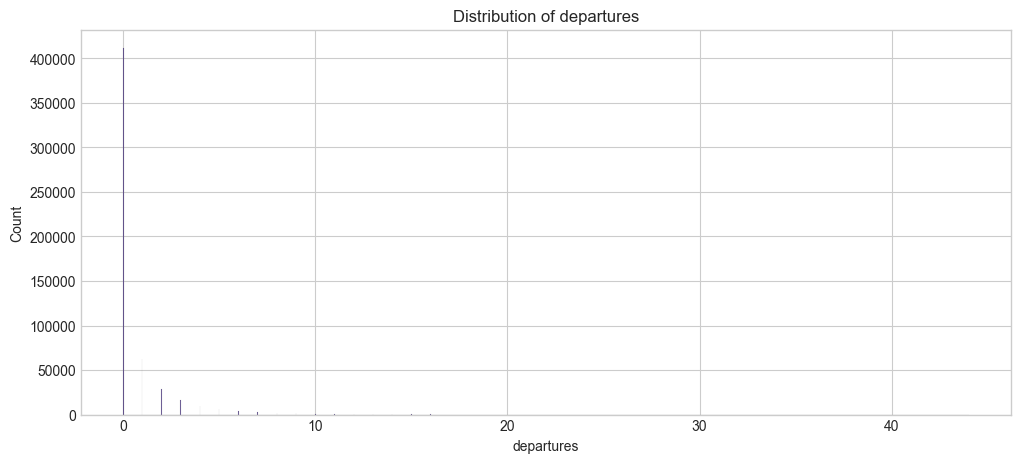

In [34]:
# Distribution of the target variable
plt.figure(figsize=(12, 5))
sns.histplot(df[CONFIG['target_col']])
plt.title(f'Distribution of {CONFIG["target_col"]}')
plt.show()

## Data preparation

In [35]:
# Prepare data for modeling
def prepare_data(df, target_col, categorical_cols, numerical_cols, time_cols, drop_cols):
    # Drop rows with NaN values
    df_clean = df.dropna()
    print(f"Dropped {len(df) - len(df_clean)} rows with NaN values.")

    # Keep datetime for visualization purposes if available
    datetime_col = df_clean['timestamp'] if 'timestamp' in df_clean.columns else None
    datetime_keeper = df_clean.copy()

    # Drop columns defined in drop_cols
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    # Split features and target
    X = df_clean[categorical_cols + numerical_cols + time_cols]
    y = df_clean[target_col]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=CONFIG['random_state'], shuffle=False)

    train_indices = X_train.index
    test_indices = X_test.index
    datetime_train = datetime_keeper.loc[train_indices, 'timestamp'] if datetime_col is not None else None
    datetime_test = datetime_keeper.loc[test_indices, 'timestamp'] if datetime_col is not None else None
    datetime_col = [datetime_train, datetime_test] if datetime_train is not None else None
   
    return X_train, y_train, X_test, y_test, datetime_col

# Test-apply data preparation
X, y, X_test, y_test, datetime_col = prepare_data(df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

print("Training set:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Dropped 0 rows with NaN values.
Training set:
Features shape: (521618, 19)
Target shape: (521618,)


In [36]:
print("Test set:")
print(f"Features shape: {X_test.shape}")
print(f"Target shape: {y_test.shape}")

Test set:
Features shape: (27454, 19)
Target shape: (27454,)


# Pipeline Definition

In [37]:

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    def _transform(X_input): # X_input will be a 2D numpy array (n_samples, 1 feature)
        # Extract the first (and only) column for calculation
        data = X_input[:, 0]
        # Perform transformation and ensure output is a 2D column vector
        return np.sin(data / period * 2 * np.pi).reshape(-1, 1)

    return FunctionTransformer(
        _transform,
        feature_names_out="one-to-one", # This allows ColumnTransformer to get feature names
        validate=True # Ensures input is 2D float numpy array and output is 2D
    )

def cos_transformer(period):
    def _transform(X_input): # X_input will be a 2D numpy array (n_samples, 1 feature)
        # Extract the first (and only) column for calculation
        data = X_input[:, 0]
        # Perform transformation and ensure output is a 2D column vector
        return np.cos(data / period * 2 * np.pi).reshape(-1, 1)

    return FunctionTransformer(
        _transform,
        feature_names_out="one-to-one", # This allows ColumnTransformer to get feature names
        validate=True # Ensures input is 2D float numpy array and output is 2D
    )

# Function to create model pipelines for each cluster
def create_model_pipelines(categorical_cols, numerical_cols, time_cols, X):
    
    preprocessor_plain = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ], remainder='passthrough')
    
    preprocessor_onehot = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('time', OneHotEncoder(handle_unknown='ignore', sparse_output=False), time_cols),
    ], remainder='passthrough')
    
    # Prepared but currently not in use
    preprocessor_sincos = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('sin_month', sin_transformer(12), ['month']),
        ('sin_hour', sin_transformer(24), ['hour']),
        ('sin_weekday', sin_transformer(7), ['weekday']),
        ('cos_month', cos_transformer(12), ['month']),
        ('cos_hour', cos_transformer(24), ['hour']),
        ('cos_weekday', cos_transformer(7), ['weekday'])
    ], remainder='passthrough')
    
    numerical_indices = [X.columns.get_loc(c) for c in numerical_cols]

    poly_transformer = ColumnTransformer([
        ("poly", PolynomialFeatures(include_bias=False), numerical_indices)
    ], remainder='passthrough')

    # Create pipelines
    pipelines = {
        'linear': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', LinearRegression())
        ]),
        
        'lasso': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', Lasso(random_state=CONFIG['random_state']))
        ]),
        
        'ridge': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', Ridge(random_state=CONFIG['random_state']))
        ]),
        'polynomial': Pipeline([
            ('preprocessing', 'passthrough'),
            ('poly', poly_transformer),
            ('regressor', LinearRegression())
        ]),
        'decision_tree': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', DecisionTreeRegressor(random_state=CONFIG['random_state']))
        ]),
        'random_forest': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', RandomForestRegressor(random_state=CONFIG['random_state']))
        ]),
        'xgboost': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=CONFIG['random_state']))
        ]),
        'gbm': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', GradientBoostingRegressor(random_state=CONFIG['random_state']))
        ])
    }
    
    # Store preprocessor strategies
    preprocessing_strategies = {
        'plain': preprocessor_plain,
        'onehot': preprocessor_onehot,
        'sincos': preprocessor_sincos
    }
    
    preprocessor_plain.strategy_name = 'Plain'
    preprocessor_onehot.strategy_name = 'OneHot'  
    preprocessor_sincos.strategy_name = 'SinCos'
    
    return pipelines, preprocessing_strategies

# Function to get parameter grids
def get_param_grids(preprocessing_strategies):
    return {
        'linear': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ]
            },
        
        'lasso': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__alpha': np.logspace(-4,4,20),
            'regressor__max_iter': [1000, 2000]
        },
        
        'ridge': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__alpha': np.logspace(-4,4,20)
        },

        'polynomial': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'poly__poly__degree': [2, 3, 4]
        },
        
        'decision_tree': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__max_depth': [3, 5, 10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'random_forest': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'xgboost': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        },
        
        'gbm': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        }
    }

# Training Functions

In [38]:
def plot_coefficients(model_name, pipeline, cluster_id):
    reg = pipeline.named_steps['regressor']
            
    feat_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
            
    # build and sort df
    coef_df = (
        pd.DataFrame({'feature': feat_names, 'coefficient': reg.coef_})
            .assign(abs_coef=lambda df: df.coefficient.abs())
            .sort_values('abs_coef', ascending=False)
            .drop(columns='abs_coef')
        )

    # largest coefficients first
    coef_df = coef_df[::-1]

    plt.figure(figsize=(14, 10))
    plt.scatter(coef_df['coefficient'], coef_df['feature'], s=50, color='C0')
    plt.axvline(0, linestyle='--', color='gray')
    plt.title(f'{model_name} Coefficients (Cluster {cluster_id})')
    plt.xlabel('Coefficient value')
    plt.ylabel('')
    #plt.tight_layout()
    plt.show()

    return coef_df

In [39]:
# Function to plot feature importance
def plot_feature_importance(model_name, model, X):
    # Extract the regressor from pipeline
    regressor = None
    for step_name, step in model.named_steps.items():
        if hasattr(step, 'feature_importances_'):
            regressor = step
            break
    
    if regressor is None:
        print(f"Model {model_name} doesn't support feature importance.")
        return
    
    # Get feature names after preprocessing
    try:
        # Try to get preprocessed feature names
        if 'preprocessing' in model.named_steps and hasattr(model['preprocessing'], 'get_feature_names_out'):
            feature_names = model['preprocessing'].get_feature_names_out()
        else:
            # Fallback to original feature names or indices
            feature_names = X.columns if hasattr(X, 'columns') else [f"feature_{i}" for i in range(X.shape[1])]
        
        # Ensure the lengths match
        if len(feature_names) != len(regressor.feature_importances_):
            print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importances length ({len(regressor.feature_importances_)})")
            # Use indices as fallback
            feature_names = [f"feature_{i}" for i in range(len(regressor.feature_importances_))]
            
        # Extract feature importances
        importance = regressor.feature_importances_
        
        # Create DataFrame for better visualization
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
        
        print(f"Feature importance report for {model_name}:")
        print(feature_imp)
        
        return feature_imp
    except Exception as e:
        print(f"Error plotting feature importance: {e}")
        return None

In [40]:
# Function to make and visualize predictions
def visualize_predictions(model_name, model, X, y, datetime_col):
    # Make predictions
    y_pred = model.predict(X)
    
    # Create a DataFrame for plotting
    pred_df = pd.DataFrame({
        'datetime': datetime_col,
        'actual': y,
        'predicted': y_pred
    })
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['datetime'], pred_df['actual'], label='Actual', alpha=0.7)
    plt.plot(pred_df['datetime'], pred_df['predicted'], label='Predicted', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted (MSE: {mse:.2f}, R²: {r2:.2f})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    pred_df['residual'] = pred_df['actual'] - pred_df['predicted']
    
    plt.figure(figsize=(15, 6))
    plt.scatter(pred_df['predicted'], pred_df['residual'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name} - Residuals Plot')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()
    
    return pred_df

In [41]:
def storeModelMetricsOnDisc(name, subset: bool, results, cluster_id):
    FILE = "checkpoints/model_train_checkpointing.csv"
    file_exists = os.path.exists(FILE)

    best_params = ' '.join(str(results['best_params']).replace('\n', '').split())
    time_string = '{date:%Y-%m-%d_%H:%M:%S}'.format(date=datetime.datetime.now())

    with open(FILE, 'a') as file:
        if not file_exists:
            file.write("timestamp,subset,model,cluster_id,best_params,best_score,rmse,mean_train_score\n")
        file.write(f"{time_string},{subset},{name},{cluster_id},{best_params},{results['best_score']},{results['rmse']},{results['mean_train_score']}\n")

In [42]:
# Function to train and evaluate a single model
def train_evaluate_model(cluster_id, subset:bool, name, pipeline, param_grid, X, y, n_splits=CONFIG['ts_splits']):
    print(f"\nTraining {name} model...")
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        gap=CONFIG['ts_gap'])
    
    # GridSearch with time series split
    grid_search = GridSearchCV(
        pipeline, 
        param_grid,
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=CONFIG['n_jobs'],
        verbose=1,
        return_train_score=True,
    )
    
    grid_search.fit(X, y)
    
    best_params = grid_search.best_params_
    if 'preprocessing' in best_params.keys():
        if hasattr(best_params['preprocessing'], 'strategy_name'):
            preproc_name = best_params['preprocessing'].strategy_name
    else:
        preproc_name = 'Unknown'
    
    # Store results
    best_model = grid_search.best_estimator_
    mean_train_scores = -grid_search.cv_results_['mean_train_score']
    mean_train_score = np.mean(mean_train_scores)
    result = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive MSE
        'rmse': np.sqrt(-grid_search.best_score_),
        'mean_train_score': mean_train_score,
    }
    
    print(f"  Best parameters: {result['best_params']}")
    print(f"  Preprocessing strategy: {preproc_name}")
    print(f"  MSE: {result['best_score']:.4f}")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  Mean Train Score: {mean_train_score}")
    storeModelMetricsOnDisc(name, subset, result, cluster_id)

    return best_model, result

In [43]:
def prepare_cluster_data(cluster_id, df_processed):

    cluster_df = df_processed[df_processed['cluster'] == cluster_id].copy()
    return prepare_data(cluster_df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

def train_cluster_models(cluster_id, X, y, models_to_train, subset: bool):

    best_models = {}
    results = {}
    
    pipelines, preprocessing_strategies = create_model_pipelines(FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], X)
    param_grids = get_param_grids(preprocessing_strategies)
    
    for model_name in models_to_train:
        if model_name in pipelines:
            best_models[model_name], results[model_name] = train_evaluate_model(
                cluster_id, subset, model_name, pipelines[model_name], param_grids[model_name], X, y
            )
    
    return best_models, results

def create_comparison_df(results_dict):

    comparison = pd.DataFrame({
        'Model': list(results_dict.keys()),
        'RMSE': [results_dict[m]['rmse'] for m in results_dict.keys()]
    }).sort_values('RMSE')
    
    return comparison

# Training Loops

## 1. Cluster Models

In [44]:
models_to_train_cluster = ['linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost']

unique_clusters = sorted(df['cluster'].unique().tolist())
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

# # Store cluster results
all_cluster_models = {}
all_cluster_results = {}
all_cluster_comparisons = {}

# Train models for each cluster
for i, cluster_id in enumerate(unique_clusters):
    print(f"\n{'='*50}\nProcessing Cluster {cluster_id}\n{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, X_cluster_test, y_cluster_test, datetime_col = prepare_cluster_data(cluster_id, df) # TODO use test sets for validation
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    models, results = train_cluster_models(cluster_id, X_cluster, y_cluster, models_to_train_cluster, subset=False)
    # time_string = '{date:%Y-%m-%d_%H:%M:%S}'.format(date=datetime.datetime.now())
    # with open(f"checkpoints/{cluster_id}-best_models-{time_string}.pkl", 'wb') as outp:
    #    pickle.dump([models, results], outp, pickle.HIGHEST_PROTOCOL)

    # Store results
    all_cluster_models[cluster_id] = models
    all_cluster_results[cluster_id] = results
    all_cluster_comparisons[cluster_id] = create_comparison_df(results)
            
    print(f"\nModel Comparison for Cluster {cluster_id}:")
    comparison_cluster = create_comparison_df(results)
    print(comparison_cluster)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
    plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show feature importance for tree-based models
    for model_name in ['xgboost', 'random_forest', 'decision_tree']:
        if model_name in models:
            print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
            feature_importance = plot_feature_importance(model_name, models[model_name], X_cluster)

    # "feature importance" for regression methods
    for model_name in ['linear', 'lasso', 'ridge']:
        if model_name in models:
            print(f"\nCoefficients for {model_name} in Cluster {cluster_id}:")
            coefficients = plot_coefficients(model_name, models[model_name], cluster_id)
    
    # Visualize best model predictions
    best_model_name = comparison_cluster['Model'].iloc[0]
    print(f"Best model for Cluster {cluster_id}: {best_model_name} with validation RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
    # Test best model on test set
    y_cluster_pred = models[best_model_name].predict(X_cluster_test)
    rmse = np.sqrt(mean_squared_error(y_cluster_test, y_cluster_pred))
    print(f"Best model on test set for Cluster {cluster_id}: {best_model_name} with test RMSE: {rmse:.4f}")

    print(f"\nVisualizing predictions on test set (5% of data) for {best_model_name} in Cluster {cluster_id}:")
    pred_df = visualize_predictions(best_model_name, models[best_model_name], X_cluster_test, y_cluster_test, datetime_col[1]) # datetime_col[1] are times corresponding to test set

    if i == CONFIG['top_n_clusters']-1:
        print(f"Reached top {CONFIG['top_n_clusters']} clusters. Stopping.")
        break

Found 10 clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Processing Cluster 0
Dropped 0 rows with NaN values.
Cluster size: 40994 records

Training linear model...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  Best parameters: {'preprocessing': ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'rain', 'snowfall',
                                  'cloud_cover', 'wind_speed_10m',
                                  'num_bikes_available', 'latitude',
                                  'longitude']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['isHoliday', 'has_kiosk', 'weather_cluster',
                                  'workhours', 'commute', 'free', 'night']),
                                ('time',
         

KeyboardInterrupt: 

In [ ]:
# Visualize results
if CONFIG['visualize_clusters']:
    visualize_cluster_results(cluster_id, models, X_cluster, y_cluster) # TODO

In [ ]:
# Create a summary of best models across clusters
summary_rows = []
for cluster_id in all_cluster_comparisons:
    best_model = all_cluster_comparisons[cluster_id].iloc[0]
    summary_rows.append({
        'Cluster': cluster_id,
        'Best Model': best_model['Model'],
        'RMSE': best_model['RMSE'],
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values('RMSE')

print("\nBest Models by Cluster:")
print(cluster_summary)

# Plot cluster performance comparison
plt.figure(figsize=(12, 6))
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot['Cluster_Model'] = cluster_summary_plot.apply(
    lambda x: f"Cluster {x['Cluster']}: {x['Best Model']}", axis=1
)
sns.barplot(x='RMSE', y='Cluster_Model', data=cluster_summary_plot)
plt.title('Best Model Performance by Cluster (RMSE - lower is better)')
plt.tight_layout()
plt.show()

In [ ]:
all_cluster_results

## 2. Citywide Models

--> Bei gutem Wetter fahren mehr Menschen Fahrrad

Out:
- Feature importance
- Coeff

Train models on all data, ignoring cluster

In [45]:
models_to_train_city = ['linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost']

In [ ]:
import copy

print(f"Models to train (citywide): {models_to_train_city}")

current_feature_cols_citywide = copy.deepcopy(FEATURE_COLS)

if 'cluster' not in current_feature_cols_citywide['drop']:
    current_feature_cols_citywide['drop'].append('cluster')
    print("Removed 'cluster' from drop cols.")

for cat_list_name in ['categorical', 'numerical', 'time']:
    if cat_list_name in current_feature_cols_citywide and 'cluster' in current_feature_cols_citywide[cat_list_name]:
        current_feature_cols_citywide[cat_list_name].remove('cluster')
        print(f"Removed 'cluster' from {cat_list_name} cols.")

X_city, y_city, X_city_test, y_city_test, datetime_col_city = prepare_data(
    df,
    CONFIG['target_col'],
    current_feature_cols_citywide['categorical'],
    current_feature_cols_citywide['numerical'],
    current_feature_cols_citywide['time'],
    current_feature_cols_citywide['drop']
)

print(f"\nCitywide training set features shape: {X_city.shape}")
print(f"Citywide training set target shape: {y_city.shape}")
print(f"Citywide test set features shape: {X_city_test.shape}")
print(f"Citywide test set target shape: {y_city_test.shape}")

city_best_models = {}
city_results = {}

pipelines_city, preprocessing_strategies_city = create_model_pipelines(
    current_feature_cols_citywide['categorical'],
    current_feature_cols_citywide['numerical'],
    current_feature_cols_citywide['time'],
    X_city
)
param_grids_city = get_param_grids(preprocessing_strategies_city)

print(f"\n{'='*50}\nTraining models for the entire city\n{'='*50}")
for model_name_item in models_to_train_city:
    if model_name_item in pipelines_city:
        city_best_models[model_name_item], city_results[model_name_item] = train_evaluate_model(
            'citywide',  # Using 'citywide' as pseudo cluster_id
            False,
            model_name_item,
            pipelines_city[model_name_item],
            param_grids_city[model_name_item],
            X_city,
            y_city
        )
    else:
        print(f"Skipping {model_name_item} as it's not defined in pipelines_city")

# Create and display comparison DataFrame for citywide models
if city_results:
    city_comparison_df = create_comparison_df(city_results)
    print("\nModel Comparison Citywide:")
    print(city_comparison_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=city_comparison_df.sort_values('RMSE', ascending=True))
    plt.title('Citywide Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()

    # Show feature importance for tree-based models
    for model_name_item in ['xgboost', 'random_forest', 'decision_tree']:
        if model_name_item in city_best_models:
            print(f"\nFeature Importance for {model_name_item} (Citywide):")
            plot_feature_importance(model_name_item, city_best_models[model_name_item], X_city)

    # Show coefficients for linear models
    for model_name_item in ['linear', 'lasso', 'ridge']:
        if model_name_item in city_best_models:
            print(f"\nCoefficients for {model_name_item} (Citywide):")
            plot_coefficients(model_name_item, city_best_models[model_name_item], 'citywide')
    
    if not city_comparison_df.empty:
        best_city_model_name = city_comparison_df['Model'].iloc[0]
        best_city_model_rmse_val = city_comparison_df['RMSE'].iloc[0]
        print(f"\nBest model for the City (based on validation RMSE): {best_city_model_name} with Validation RMSE: {best_city_model_rmse_val:.4f}")
        
        y_cluster_pred = models[best_model_name].predict(X_cluster_test)

        # Test best model on the citywide test set
        y_city_pred_test = city_best_models[best_city_model_name].predict(X_city_test)
        city_test_rmse = np.sqrt(mean_squared_error(y_city_test, y_city_pred_test))
        r2_city_test = r2_score(y_city_test, y_city_pred_test)
        print(f"Best city model ({best_city_model_name}) on Test Set: RMSE: {city_test_rmse:.4f}, R²: {r2_city_test:.4f}")

        print(f"\nVisualizing predictions on test set for {best_city_model_name} (Citywide):")
        # datetime_col_city[0] is train datetime, datetime_col_city[1] is test datetime
        visualize_predictions(best_city_model_name, city_best_models[best_city_model_name], X_city_test, y_city_test, datetime_col_city[1])
    else:
        print("No models for citywide")
else:
    print("No results for citywide")


Models to train (citywide): ['linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost']
Dropped 0 rows with NaN values.

Citywide training set features shape: (521618, 19)
Citywide training set target shape: (521618,)
Citywide test set features shape: (27454, 19)
Citywide test set target shape: (27454,)

Training models for the entire city


TypeError: train_evaluate_model() missing 1 required positional argument: 'y'

## 3. Subset Models (May 10-20)

TODO

- Split data to range from May 10 - 20
- Adjust checkpointing to include column about this split (bool)
- Train **all** models on this data, including random forest

In [ ]:
# Note: this obviously only works if the df is not sampled via CONFIG['sample'] = True

df_may = df[
    (df['timestamp'].dt.month == 5) &
    (df['timestamp'].dt.day >= 10) & 
    (df['timestamp'].dt.day <= 20)
].copy()

print(f"Shape of df_may_subset: {df_may.shape}")
df_may.head()

In [ ]:
# Random forest first to detect potential errors early
models_to_train_cluster_may = ['random_forest', 'linear', 'lasso', 'ridge', 'polynomial', 'decision_tree', 'xgboost']

unique_clusters = sorted(df_may['cluster'].unique().tolist())
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

# # Store cluster results
all_cluster_models = {}
all_cluster_results = {}
all_cluster_comparisons = {}

# Train models for each cluster
for i, cluster_id in enumerate(unique_clusters):
    print(f"\n{'='*50}\nProcessing Cluster {cluster_id}\n{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, X_cluster_test, y_cluster_test, datetime_col = prepare_cluster_data(cluster_id, df) # TODO use test sets for validation
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    models, results = train_cluster_models(cluster_id, X_cluster, y_cluster, models_to_train_cluster, subset=True)

    # Store results
    all_cluster_models[cluster_id] = models
    all_cluster_results[cluster_id] = results
    all_cluster_comparisons[cluster_id] = create_comparison_df(results)
            
    print(f"\nModel Comparison for Cluster {cluster_id}:")
    comparison_cluster = create_comparison_df(results)
    print(comparison_cluster)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
    plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show feature importance for tree-based models
    for model_name in ['xgboost', 'random_forest', 'decision_tree']:
        if model_name in models:
            print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
            feature_importance = plot_feature_importance(model_name, models[model_name], X_cluster)

    # "feature importance" for regression methods
    for model_name in ['linear', 'lasso', 'ridge']:
        if model_name in models:
            print(f"\nCoefficients for {model_name} in Cluster {cluster_id}:")
            coefficients = plot_coefficients(model_name, models[model_name], cluster_id)
    
    # Visualize best model predictions
    best_model_name = comparison_cluster['Model'].iloc[0]
    print(f"Best model for Cluster {cluster_id}: {best_model_name} with validation RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
    # Test best model on test set
    y_cluster_pred = models[best_model_name].predict(X_cluster_test)
    rmse = np.sqrt(mean_squared_error(y_cluster_test, y_cluster_pred))
    print(f"Best model on test set for Cluster {cluster_id}: {best_model_name} with test RMSE: {rmse:.4f}")

    print(f"\nVisualizing predictions on test set (5% of data) for {best_model_name} in Cluster {cluster_id}:")
    pred_df = visualize_predictions(best_model_name, models[best_model_name], X_cluster_test, y_cluster_test, datetime_col[1]) # datetime_col[1] are times corresponding to test set

    if i == CONFIG['top_n_clusters']-1:
        print(f"Reached top {CONFIG['top_n_clusters']} clusters. Stopping.")
        break

In [ ]:
# Create a summary of best models across clusters
summary_rows = []
for cluster_id in all_cluster_comparisons:
    best_model = all_cluster_comparisons[cluster_id].iloc[0]
    summary_rows.append({
        'Cluster': cluster_id,
        'Best Model': best_model['Model'],
        'RMSE': best_model['RMSE'],
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values('RMSE')

print("\nBest Models by Cluster:")
print(cluster_summary)

# Plot cluster performance comparison
plt.figure(figsize=(12, 6))
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot['Cluster_Model'] = cluster_summary_plot.apply(
    lambda x: f"Cluster {x['Cluster']}: {x['Best Model']}", axis=1
)
sns.barplot(x='RMSE', y='Cluster_Model', data=cluster_summary_plot)
plt.title('Best Model Performance by Cluster (RMSE - lower is better)')
plt.tight_layout()
plt.show()

In [ ]:
all_cluster_results